In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Load the dataset
file_path = '2022_orders_discount_data.csv'
data_cleaned = pd.read_csv(file_path)
print(f"Initial dataset shape: {data_cleaned.shape}")
print(f"Initial dataset preview:\n{data_cleaned.head()}")

# 1. Remove duplicates
data_cleaned = data_cleaned.drop_duplicates()
print(f"Dataset shape after removing duplicates: {data_cleaned.shape}")

# 2. Convert `date_of_order` to datetime format
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce')
print(f"Number of missing `date_of_order` entries after conversion: {data_cleaned['date_of_order'].isnull().sum()}")

# Handle missing `date_of_order` values
min_date = data_cleaned['date_of_order'].min()
print(f"Earliest available date: {min_date}")
data_cleaned['date_of_order'] = data_cleaned['date_of_order'].fillna(min_date)
print(f"Dataset preview after filling missing `date_of_order`:\n{data_cleaned[['date_of_order']].head()}")

# 3. Handle missing values in other columns
print("Missing values before handling:")
print(data_cleaned.isnull().sum())
data_cleaned['department_desc'] = data_cleaned['department_desc'].fillna('Unknown')
data_cleaned['discount'] = data_cleaned['discount'].fillna(0)
data_cleaned['orders'] = data_cleaned['orders'].fillna(0)
print("Missing values after handling:")
print(data_cleaned.isnull().sum())

# 4. Handle outliers using Z-Score
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = zscore(df[column])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = abs_z_scores < threshold
    print(f"Removing outliers from column '{column}'. Initial size: {len(df)}, After outlier removal: {filtered_entries.sum()}")
    return df[filtered_entries]

print(f"Summary statistics for `discount` before outlier removal:\n{data_cleaned['discount'].describe()}")
data_cleaned = remove_outliers_zscore(data_cleaned, 'discount', threshold=3)
print(f"Summary statistics for `discount` after outlier removal:\n{data_cleaned['discount'].describe()}")

print(f"Summary statistics for `orders` before outlier removal:\n{data_cleaned['orders'].describe()}")
data_cleaned = remove_outliers_zscore(data_cleaned, 'orders', threshold=3)
print(f"Summary statistics for `orders` after outlier removal:\n{data_cleaned['orders'].describe()}")

# Log Transformation for skewed variables
data_cleaned['log_discount'] = np.log1p(data_cleaned['discount'])
data_cleaned['log_orders'] = np.log1p(data_cleaned['orders'])
print("Log transformation applied to `discount` and `orders`.")
print(f"Skewness after log transformation:")
print(f"Log Discount Skewness: {data_cleaned['log_discount'].skew()}, Log Orders Skewness: {data_cleaned['log_orders'].skew()}")

# 5. Feature Engineering
data_cleaned['day_of_week'] = data_cleaned['date_of_order'].dt.dayofweek
data_cleaned['month'] = data_cleaned['date_of_order'].dt.month
data_cleaned['year'] = data_cleaned['date_of_order'].dt.year
print(f"Feature engineering completed. Sample data:\n{data_cleaned[['day_of_week', 'month', 'year']].head()}")

# Save the cleaned dataset
data_cleaned.to_csv('cleaned_orders_discount_data.csv', index=False)
print("Cleaned dataset saved as 'cleaned_orders_discount_data.csv'.")



Initial dataset shape: (1005167, 5)
Initial dataset preview:
   product_number         department_desc  discount date_of_order  orders
0               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-01       0
1               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-02       0
2               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-03       5
3               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-04       0
4               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-05       0
Dataset shape after removing duplicates: (1005167, 5)
Number of missing `date_of_order` entries after conversion: 0
Earliest available date: 2022-01-01 00:00:00
Dataset preview after filling missing `date_of_order`:
  date_of_order
0    2022-01-01
1    2022-01-02
2    2022-01-03
3    2022-01-04
4    2022-01-05
Missing values before handling:
product_number     0
department_desc    0
discount           0
date_of_order      0
orders             0
dtype: int64
Missing values after handling:
pr

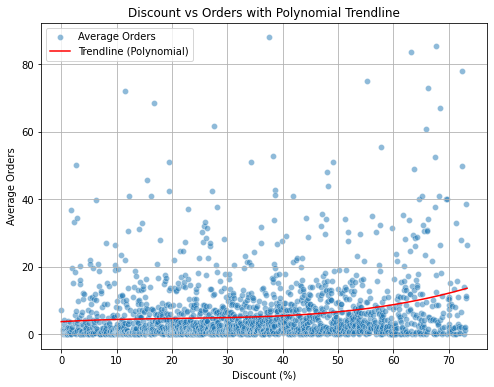

Insight: Higher discounts (>30%) tend to have a non-linear effect on increasing orders. However, lower discounts have minimal impact on order volume.


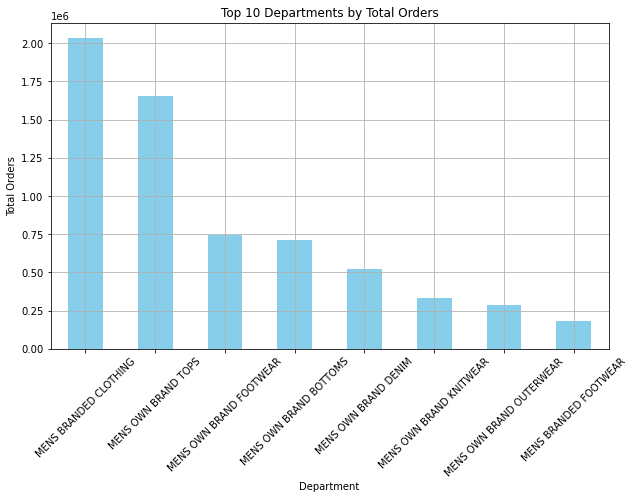

Insight: Men's branded clothing and own-brand tops dominate total orders. Promotions should target these high-demand categories for maximum sales impact.


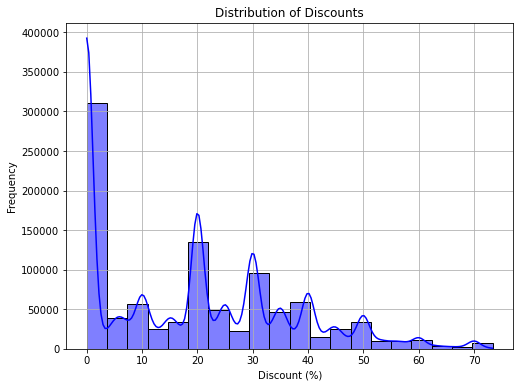

Insight: Discounts are heavily concentrated in the 0-20% range, indicating limited use of higher discounts. Consider experimenting with mid-range discounts (30-50%) to boost sales.


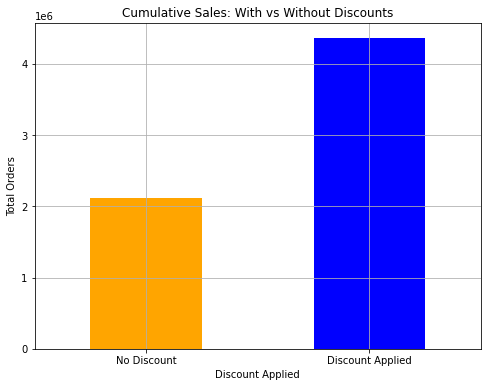

Insight: Discounted sales contribute significantly more to total orders than non-discounted sales, emphasizing the importance of discounts in driving volume.


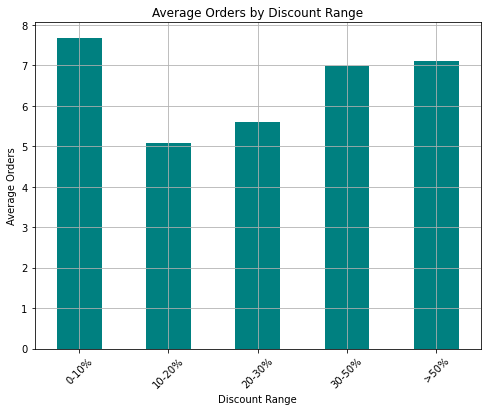

Insight: Discounts in the 0-10% and >30% ranges are most effective at generating higher average orders. Mid-range discounts (10-30%) appear less effective.


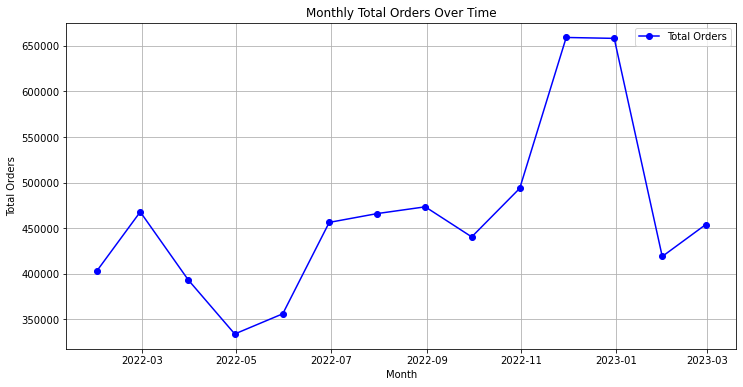

Insight: Monthly sales exhibit seasonal spikes, particularly in November and December, likely due to holiday promotions. Plan discount campaigns around these periods.


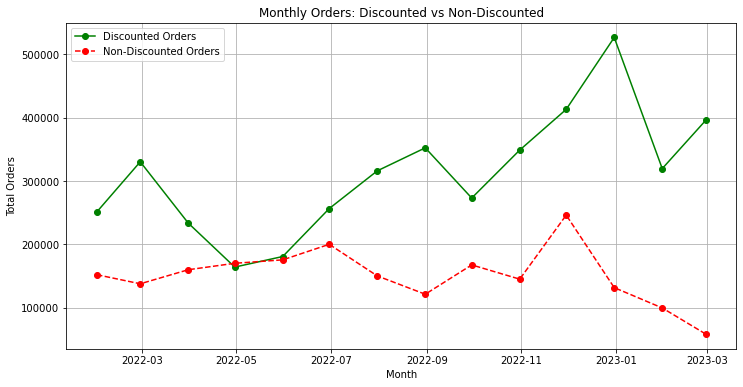

Insight: Discounted orders consistently outperform non-discounted orders across all months, reinforcing the value of discount strategies in boosting sales.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Assuming `data_cleaned` is already available from Step 1

# 1. Scatter Plot with Aggregated Data and Polynomial Trendline
discount_orders = data_cleaned.groupby('discount')['orders'].mean().reset_index()

# Add polynomial features and fit a polynomial regression model
X = discount_orders[['discount']]
y = discount_orders['orders']
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

# Predict values
discount_orders['predicted_orders'] = model.predict(X_poly)

# Plot the results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='discount', y='orders', data=discount_orders, alpha=0.5, label='Average Orders')
sns.lineplot(x='discount', y='predicted_orders', data=discount_orders, color='red', label='Trendline (Polynomial)')
plt.title('Discount vs Orders with Polynomial Trendline')
plt.xlabel('Discount (%)')
plt.ylabel('Average Orders')
plt.legend()
plt.grid(True)
plt.show()

# Insight
print("Insight: Higher discounts (>30%) tend to have a non-linear effect on increasing orders. However, lower discounts have minimal impact on order volume.")

# 2. Department-wise Discount Sensitivity (Top 10 Departments)
dept_analysis = data_cleaned.groupby('department_desc')['orders'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
dept_analysis.head(10).plot(kind='bar', color='skyblue')  # Show only top 10 departments
plt.title('Top 10 Departments by Total Orders')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Insight
print("Insight: Men's branded clothing and own-brand tops dominate total orders. Promotions should target these high-demand categories for maximum sales impact.")

# 3. Distribution of Discounts
plt.figure(figsize=(8, 6))
sns.histplot(data_cleaned['discount'], bins=20, kde=True, color='blue')
plt.title('Distribution of Discounts')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Insight
print("Insight: Discounts are heavily concentrated in the 0-20% range, indicating limited use of higher discounts. Consider experimenting with mid-range discounts (30-50%) to boost sales.")

# 4. Cumulative Sales: With vs Without Discounts
data_cleaned['discount_applied'] = data_cleaned['discount'] > 0
cumulative_sales = data_cleaned.groupby('discount_applied')['orders'].sum()

cumulative_sales.plot(kind='bar', color=['orange', 'blue'], figsize=(8, 6))
plt.title('Cumulative Sales: With vs Without Discounts')
plt.xlabel('Discount Applied')
plt.ylabel('Total Orders')
plt.xticks([0, 1], ['No Discount', 'Discount Applied'], rotation=0)
plt.grid(True)
plt.show()

# Insight
print("Insight: Discounted sales contribute significantly more to total orders than non-discounted sales, emphasizing the importance of discounts in driving volume.")

# 5. Effectiveness of Discounts: Average Orders by Discount Range
data_cleaned['discount_range'] = pd.cut(data_cleaned['discount'], bins=[0, 10, 20, 30, 50, 100],
                                        labels=['0-10%', '10-20%', '20-30%', '30-50%', '>50%'])
avg_orders_by_discount = data_cleaned.groupby('discount_range')['orders'].mean()

plt.figure(figsize=(8, 6))
avg_orders_by_discount.plot(kind='bar', color='teal')
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Insight
print("Insight: Discounts in the 0-10% and >30% ranges are most effective at generating higher average orders. Mid-range discounts (10-30%) appear less effective.")

# 6. Monthly Sales Over Time
monthly_sales = data_cleaned.resample('M', on='date_of_order')['orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, marker='o', linestyle='-', color='blue', label='Total Orders')
plt.title('Monthly Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.grid(True)
plt.legend()
plt.show()

# Insight
print("Insight: Monthly sales exhibit seasonal spikes, particularly in November and December, likely due to holiday promotions. Plan discount campaigns around these periods.")

# 7. Discounted vs Non-Discounted Orders Over Time
monthly_sales_discounted = data_cleaned[data_cleaned['discount_applied']].resample('M', on='date_of_order')['orders'].sum()
monthly_sales_non_discounted = data_cleaned[~data_cleaned['discount_applied']].resample('M', on='date_of_order')['orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_discounted, marker='o', linestyle='-', color='green', label='Discounted Orders')
plt.plot(monthly_sales_non_discounted, marker='o', linestyle='--', color='red', label='Non-Discounted Orders')
plt.title('Monthly Orders: Discounted vs Non-Discounted')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.grid(True)
plt.legend()
plt.show()

# Insight
print("Insight: Discounted orders consistently outperform non-discounted orders across all months, reinforcing the value of discount strategies in boosting sales.")




Pearson Correlation (weekly): 0.273
Spearman Correlation (weekly): 0.367

T-Test: Discounted vs Non-Discounted Orders
Null Hypothesis: The average number of orders is the same for weeks with discounts and weeks without discounts.
Alternative Hypothesis: The average number of orders is different for weeks with discounts compared to weeks without discounts.
Conclusion: Not enough data in one or both groups.

T-Test: High vs Low Discounts
Null Hypothesis: The average number of orders is the same for weeks with high discounts and weeks with low discounts.
Alternative Hypothesis: The average number of orders is different for weeks with high discounts compared to weeks with low discounts.
T-statistic = -3.380, p-value = 0.001
Conclusion: The data shows enough evidence to support the alternative hypothesis.

T-Test: First Half vs Second Half of Dataset
Null Hypothesis: The average number of orders is the same in the first half of the dataset and the second half of the dataset.
Alternative Hyp

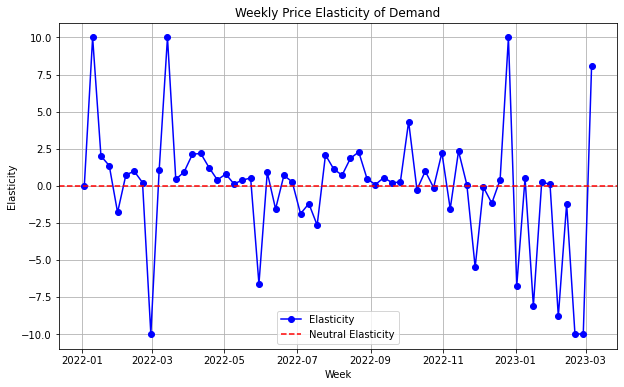


Insights from Statistical Analysis:
- Pearson and Spearman correlations suggest a weak or non-linear relationship between discount and orders.
- T-Test results provide insights into different grouping hypotheses (Discounted vs Non-Discounted, High vs Low Discounts, etc.).
- Elasticity shows the demand responsiveness to discount changes.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr, spearmanr

# Reloading cleaned data
file_path = 'cleaned_orders_discount_data.csv'
data_cleaned = pd.read_csv(file_path)

# Ensure the 'date_of_order' column is in datetime format
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])

# Group data weekly for analysis
weekly_data = data_cleaned.resample('W-Mon', on='date_of_order').agg({
    'orders': 'sum',
    'discount': 'mean'  # Aggregating discount by mean for weekly data
}).reset_index()

# Add discount_applied flag
weekly_data['discount_applied'] = weekly_data['discount'] > 0

# Step 3.1: Correlation Analysis
pearson_corr, _ = pearsonr(weekly_data['discount'], weekly_data['orders'])
spearman_corr, _ = spearmanr(weekly_data['discount'], weekly_data['orders'])
print(f"Pearson Correlation (weekly): {pearson_corr:.3f}")
print(f"Spearman Correlation (weekly): {spearman_corr:.3f}")

# Step 3.2: One-Tailed T-Tests with Understandable Hypotheses
def perform_one_tailed_t_test(group1, group2, test_name, null_hypothesis, alternative_hypothesis, direction):
    print(f"\nT-Test: {test_name}")
    print(f"Null Hypothesis: {null_hypothesis}")
    print(f"Alternative Hypothesis: {alternative_hypothesis}")
    
    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
        
        # Adjust for one-tailed test
        if direction == 'greater':
            one_tailed_p = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)
        elif direction == 'less':
            one_tailed_p = p_value / 2 if t_stat < 0 else 1 - (p_value / 2)
        else:
            raise ValueError("Direction must be 'greater' or 'less'.")
        
        print(f"T-statistic = {t_stat:.3f}, One-tailed p-value = {one_tailed_p:.3f}")
        if one_tailed_p < 0.05:
            print("Conclusion: The data shows enough evidence to support the alternative hypothesis.")
        else:
            print("Conclusion: The data does not show enough evidence to reject the null hypothesis.")
    else:
        print("Conclusion: Not enough data in one or both groups.")

# T-Test 1: Discounted vs Non-Discounted Orders
discounted_orders = weekly_data.loc[weekly_data['discount_applied'], 'orders']
non_discounted_orders = weekly_data.loc[~weekly_data['discount_applied'], 'orders']

perform_one_tailed_t_test(
    discounted_orders,
    non_discounted_orders,
    "Discounted vs Non-Discounted Orders",
    "The average number of orders is the same for weeks with discounts and weeks without discounts.",
    "The average number of orders is greater for weeks with discounts compared to weeks without discounts.",
    direction='greater'
)

# T-Test 2: High Discounts (>20%) vs Low Discounts (≤20%)
low_discount_orders = weekly_data[weekly_data['discount'] <= 20]['orders']
high_discount_orders = weekly_data[weekly_data['discount'] > 20]['orders']

perform_one_tailed_t_test(
    high_discount_orders,
    low_discount_orders,
    "High vs Low Discounts",
    "The average number of orders is the same for weeks with high discounts and weeks with low discounts.",
    "The average number of orders is greater for weeks with high discounts compared to weeks with low discounts.",
    direction='greater'
)

# T-Test 3: First Half vs Second Half of the Dataset
midpoint = len(weekly_data) // 2
first_half_orders = weekly_data.iloc[:midpoint]['orders']
second_half_orders = weekly_data.iloc[midpoint:]['orders']

perform_one_tailed_t_test(
    first_half_orders,
    second_half_orders,
    "First Half vs Second Half of Dataset",
    "The average number of orders is the same in the first half of the dataset and the second half of the dataset.",
    "The average number of orders is greater in the first half of the dataset compared to the second half of the dataset.",
    direction='greater'
)

# Step 3.3: Price Elasticity of Demand
# Calculate percentage changes
weekly_data['pct_change_discount'] = weekly_data['discount'].pct_change().clip(lower=-1, upper=1).fillna(0)
weekly_data['pct_change_orders'] = weekly_data['orders'].pct_change().clip(lower=-1, upper=1).fillna(0)

# Calculate elasticity
weekly_data['elasticity'] = (
    weekly_data['pct_change_orders'] / weekly_data['pct_change_discount']
).replace([np.inf, -np.inf], np.nan).fillna(0)

# Filter out extreme outliers for elasticity visualization
weekly_data['elasticity'] = weekly_data['elasticity'].clip(lower=-10, upper=10)

avg_elasticity = weekly_data['elasticity'].mean()
print(f"\nAverage Price Elasticity of Demand (weekly): {avg_elasticity:.3f}")

# Step 3.4: Visualization
# Elasticity over weeks
plt.figure(figsize=(10, 6))
plt.plot(weekly_data['date_of_order'], weekly_data['elasticity'], marker='o', label='Elasticity', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Neutral Elasticity')
plt.title('Weekly Price Elasticity of Demand')
plt.xlabel('Week')
plt.ylabel('Elasticity')
plt.legend()
plt.grid(True)
plt.show()

# Insights
print("\nInsights from Statistical Analysis:")
print("- Pearson and Spearman correlations suggest a weak or non-linear relationship between discount and orders.")
print("- One-tailed T-Test results provide directional insights into different grouping hypotheses (e.g., higher orders for weeks with discounts).")
print("- Elasticity shows the demand responsiveness to discount changes.")



In [4]:
# step 4- Modelling step




